# **1. Environment Set Up**

In [ ]:
!pip install xlrd
!pip install darts

In [ ]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict, Optional
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *

# **2. Evaluation Function**


> Defining the horizon to be predicted using using sMAPE (Symmetric Mean Absolute Percentage Error)



In [ ]:
# prediction horizon
HORIZON = 9

In [ ]:
def eval_forecasts(
    pred_series: List[TimeSeries], test_series: List[TimeSeries]
) -> List[float]:

    print("computing sMAPEs...")
    smapes = smape(test_series, pred_series)
    plt.figure()
    plt.hist(smapes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("Median sMAPE: %.3f" % np.median(smapes))
    plt.show()
    plt.close()
    return smapes

# **3. Data Loading and Preparation**

> Downloads and loads data, preprocesses it, and plots random series for visualization.



In [ ]:
!pip install gdown

In [ ]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import random

In [ ]:
# Google Drive URLs for the .npy files
url_categ = "https://drive.google.com/uc?id=1UiZliu_AQdlkjRhVf61Cc0_iJNvIbSyJ"
url_train = "https://drive.google.com/uc?id=1hIkzsOiDMX5B7pwxyJkiOEBV1nW6_cOB"
url_valid = "https://drive.google.com/uc?id=1nV6ugTmqf--NTzBZCpb80PO0YZmsjigs"

# Function to download and load a .npy file
def download_and_load_npy(url):
    output_file = gdown.download(url, quiet=True)
    return np.load(output_file)

# Downloading and reading the .npy files
categories = download_and_load_npy(url_categ)
training_dataset = download_and_load_npy(url_train)
validation_periods = download_and_load_npy(url_valid)

In [ ]:
def remove_null_from_array(x):
    return x[x != 0]

In [ ]:
tr_data = []
for i in range(len(training_dataset)):
    tr_data.append(remove_null_from_array(training_dataset[i]))

In [ ]:
len(tr_data[8])

803

In [ ]:
def plot_random_series(list_of_series):
    figure, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=100)

    for i, idx in enumerate([1, 2, 10, 50, 70, 100]):
        axis = ax[i % 3, i % 2]
        axis.plot(list_of_series[idx])
        axis.set_title(f"series: {idx}")
    plt.tight_layout()

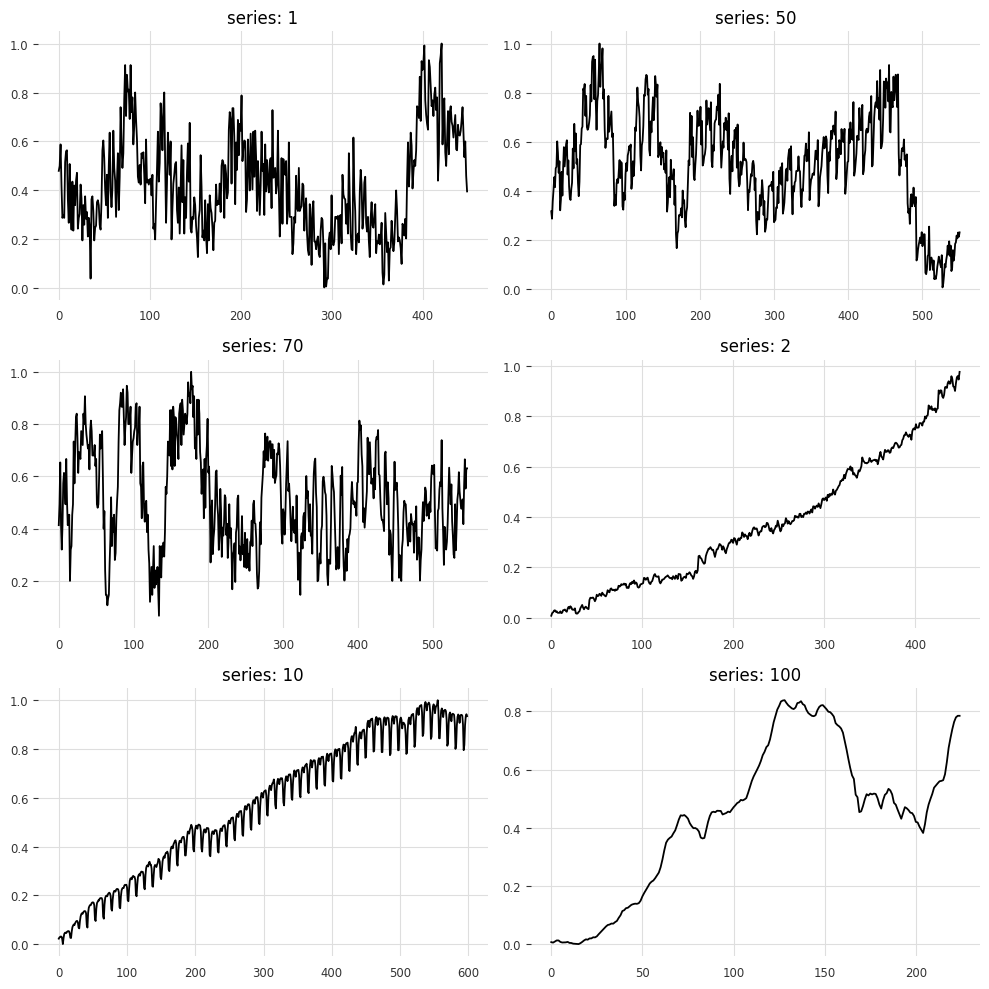

In [ ]:
plot_random_series(tr_data)

tr_data looks like it's on the nice format to be used

# **4. Model Evaluation - Prepared Data**

> Evaluates the performance of two traditional time series forecasting models (NaiveSeasonal and Theta) on the prepared data. The sMAPE and time taken for each model are computed and displayed. It also filters out shorter time series for training and testing.



In [ ]:
def eval_local_model(
    train_series: List[TimeSeries], test_series: List[TimeSeries], model_cls, **kwargs
) -> Tuple[List[float], float]:
    preds = []
    start_time = time.time()
    for series in tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

In [ ]:
tr_data = [inner_list for inner_list in tr_data if len(inner_list) >= 50]

In [ ]:
trainv = []
testv = []
for i in range(len(tr_data)):
    tr_data[i] = TimeSeries.from_values(tr_data[i])
    trainv.append(tr_data[i][0:-HORIZON])
    testv.append(tr_data[i][-HORIZON:])

In [ ]:
len(trainv)

45132

In [ ]:
len(testv)

45132

In [ ]:
len(tr_data[8])

803

In [ ]:
len(trainv[8])

794

In [ ]:
len(testv[8])

9

In [ ]:
naive1_smapes, naive1_time = eval_local_model(trainv, testv, NaiveSeasonal, K=1)

  0%|          | 0/45132 [00:00<?, ?it/s]

computing sMAPEs...


KeyboardInterrupt: 

In [ ]:
theta_smapes, theta_time = eval_local_model(trainv, testv, Theta, theta=1.5)

Given this results, we can see that traditional approaches can create results for the time series data. However, now we should deal with Neural Networks approach in order to try extracting better results.

## **5. N-BEATS Model Initialization and Training**

> Defines hyperparameters for the N-BEATS model, filters time series data based on length, initializes and trains the N-BEATS model using PyTorch Lightning. The script also evaluates the model on the test data, saves the model, and displays its summary using torchsummary. Additionally, it builds a Keras model with the same structure as the PyTorch model. Note that there is an issue with the import of build_model in the last line.



In [ ]:
### Possible N-BEATS hyper-parameters

# Slicing hyper-params:

#Setting WINDOW <= output_chunk_length prevents auto-regression.
IN_LEN = 200
OUT_LEN = 3


# Architecture hyper-params:
NUM_STACKS = 10
NUM_BLOCKS = 1
NUM_LAYERS = 2
LAYER_WIDTH = 33
COEFFS_DIM = 4

# Training settings:
LR = 1e-4
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 10
NUM_EPOCHS = 10

In [ ]:
filtered_train = []
filtered_test = []
for i in range(len(trainv)):
    if len(trainv[i]) >= 210:
        filtered_train.append(trainv[i])
        filtered_test.append(testv[i])

In [ ]:
len(filtered_train)

19584

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

In [ ]:
# reproducibility
np.random.seed(72)
torch.manual_seed(72)

nbeats_model_air = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    batch_size=BATCH_SIZE,
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": LR},
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        # change this one to "gpu" if your notebook does run in a GPU environment:
        "accelerator": "gpu",
        "callbacks": [my_stopper]
    },
)

nbeats_model_air.fit(filtered_train, num_loader_workers=4, epochs=NUM_EPOCHS)

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

NameError: name 'filtered_t' is not defined

In [ ]:
# get predictions
nb_preds = nbeats_model_air.predict(series=filtered_train, n=HORIZON)

nbeats_smapes = eval_forecasts(nb_preds, filtered_test)

ValueError: All input series must have length >= `input_chunk_length` (200).

computing sMAPEs...


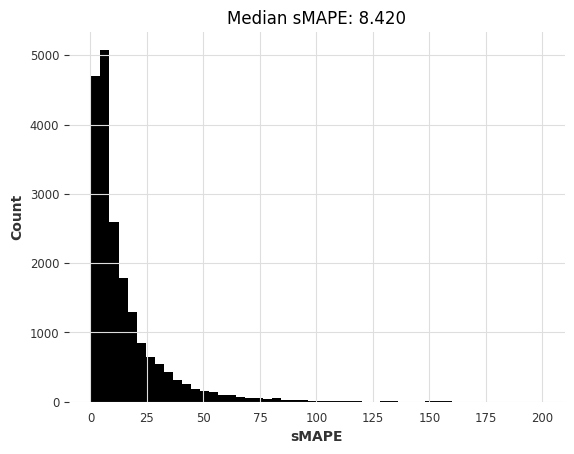

In [ ]:
nbeats_smapes = eval_forecasts(nb_preds, filtered_test)

In [ ]:
torch.save(nbeats_model_air, 'entire_model.pth')

In [ ]:
!pip install torchsummary